# Run Objective:

### Run0130-SERIES

###### Run0132
Based on Run0130 but missing dimensionality reducing encoder sub-module.

-  `Run0132`

CURRENT SITUATION:
I've been successfully been able to build my Late Fusion module with the following features (threshold matching, variable gradient - linear). I have not yet been able to do the power module. i.e.:

I thought I could do this with a Keras custom layer doing (effectively x ** c_3). I've realized that this approach is probably not going to work (I can't rely on outputs for a start, only the weights and biases). My current idea is to use a sub-network as a Taylor Series approximator:

Run0132
Based on Run0130 but missing dimensionality reducing encoder sub-module.

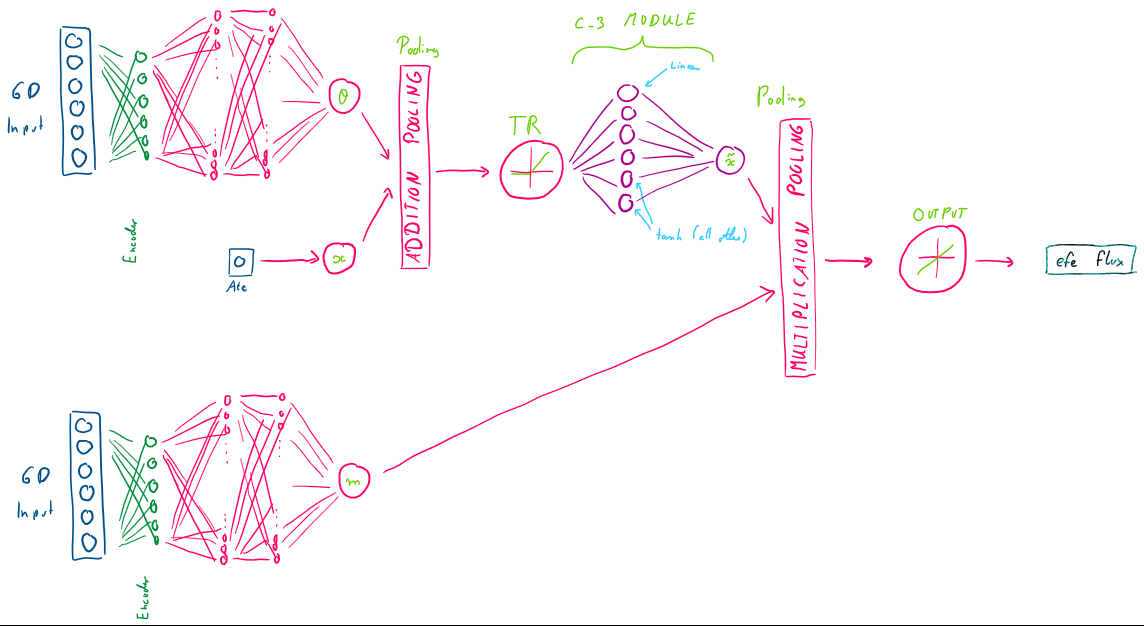

In [ ]:
# DO NOT RUN THIS PART

In [ ]:
import os
import sys
import time

# Gets the current file name. Useful for procedurally generating output/log files.
file_name =  os.path.basename(sys.argv[0][:-3])
print(file_name)

if file_name == "ipykernel_launcher":
    print("This is the Jupyter version.")
    print("Now MANUALLY run the next two cells!")
    print("STOP! This should not be in your code!!")
    exit(0)
    time.sleep(10)
    print("Testing if script has really stopped.")
else:
    print("This is the Atom version")

In [1]:
# RUN ONLY IN JUPYTER!!
# Start here (manual)

In [2]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"');

<IPython.core.display.Javascript object>

In [3]:
print(file_name)

2018-10-29_Run0133.ipynb


In [4]:
file_name = file_name[:-6]
print(file_name)

is_Jupyter = True
print(is_Jupyter)

2018-10-29_Run0133
True


In [5]:
# Same code for both ATOM & JUPYTER from now (Run all cells below now)

In [6]:
'''
Late Fusion Module (test) - Functional API
'''

# Multiple Inputs
import keras
from keras.optimizers import RMSprop, adam, Adam
from keras.initializers import TruncatedNormal, glorot_normal, Constant
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from keras import regularizers
from keras import backend as K
from keras.backend import switch
import pandas
import numpy
import sys
import os
from copy import deepcopy
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers.advanced_activations import ThresholdedReLU

keras.backend.clear_session()

Using TensorFlow backend.


In [7]:
# Define new Metric: rmse = Root Mean Square Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square( y_true-y_pred )))

In [ ]:
# Modify for ATOM use

In [ ]:
if is_Jupyter == True:
    pass
else:
    # Gets the current file name. Useful for procedurally generating output/log files.
    file_name =  os.path.basename(sys.argv[0][:-3])

In [ ]:
# Define neural network parameters
batch_size = 10
#num_classes = 1
epochs = 100

In [ ]:
# Load Data (which is in HDF5 or .h5 format)
store = pandas.HDFStore("training_gen3_7D_nions0_flat_filter8.h5")
target_df = store['/output/efeETG_GB'].to_frame()  # This one is relatively easy to train
input_df = store['input']

# Puts inputs and outputs in the same pandas dataframe.
# Also only keeps overlapping entries.
joined_dataFrame = target_df.join(input_df)

# Make a copy of joined_dataFrame for later use
joined_dataFrame_original = deepcopy(joined_dataFrame)


# *************************************************************************** #
# Normalize data by standard deviation and mean-centering the data
# Standard configuration
joined_dataFrame['efeETG_GB'] = (joined_dataFrame['efeETG_GB'] - joined_dataFrame['efeETG_GB'].mean()) / joined_dataFrame['efeETG_GB'].std()
joined_dataFrame['Ati'] = (joined_dataFrame['Ati'] - joined_dataFrame['Ati'].mean()) / joined_dataFrame['Ati'].std()
joined_dataFrame['Ate'] = (joined_dataFrame['Ate'] - joined_dataFrame['Ate'].mean()) / joined_dataFrame['Ate'].std()
joined_dataFrame['An'] = (joined_dataFrame['An'] - joined_dataFrame['An'].mean()) / joined_dataFrame['An'].std()
joined_dataFrame['q'] = (joined_dataFrame['q'] - joined_dataFrame['q'].mean()) / joined_dataFrame['q'].std()
joined_dataFrame['smag'] = (joined_dataFrame['smag'] - joined_dataFrame['smag'].mean()) / joined_dataFrame['smag'].std()
joined_dataFrame['x'] = (joined_dataFrame['x'] - joined_dataFrame['x'].mean()) / joined_dataFrame['x'].std()
joined_dataFrame['Ti_Te'] = (joined_dataFrame['Ti_Te'] - joined_dataFrame['Ti_Te'].mean()) / joined_dataFrame['Ti_Te'].std()

# Shuffles dataset
shuffled_joined_dataFrame = joined_dataFrame.reindex(numpy.random.permutation(
                                                joined_dataFrame.index))

# Creates a pandas dataframe for the outputs
shuffled_clean_output_df = shuffled_joined_dataFrame['efeETG_GB']

# Make a copy of shuffled_joined_dataFrame for later use
shuffled_joined_dataFrame_base = deepcopy(shuffled_joined_dataFrame)



# *************************************************************************** #
# Creates a pandas dataframe for the inputs (7D)
shuffled_clean_input_df_7D = shuffled_joined_dataFrame.drop('efeETG_GB', axis=1)

# Creates training dataset (90% of total data) for outputs
y_train = shuffled_clean_output_df.iloc[:int(
    numpy.round(len(shuffled_clean_output_df)*0.9))]

# Creates training dataset (90% of total data) for inputs
x_train = shuffled_clean_input_df_7D.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9))]

# Creates testing dataset (10% of total data) for outputs
y_test = shuffled_clean_output_df.iloc[int(
    numpy.round(len(shuffled_clean_output_df)*0.9)):]

# Creates testing dataset (10% of total data) for inputs
x_test = shuffled_clean_input_df_7D.iloc[int(
    numpy.round(len(shuffled_clean_input_df_7D)*0.9)):]
# *************************************************************************** #


# Deletes pandas dataframes that are no longer needed
del target_df, input_df

# Closes the HDFStore. This is good practice.
store.close()


In [ ]:
shuffled_clean_input_df_7D.describe(include='all')

In [ ]:
# Creates a pandas dataframe for the inputs
shuffled_clean_input_df_1 = shuffled_clean_input_df_7D.drop('Ate', axis=1)

In [ ]:
shuffled_clean_input_df_1.describe(include='all')

In [ ]:
print(shuffled_clean_input_df_1.shape)

In [ ]:
shuffled_clean_input_df_2 = shuffled_clean_input_df_7D.drop('Ati', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('An', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('q', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('smag', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('x', axis=1)
shuffled_clean_input_df_2 = shuffled_clean_input_df_2.drop('Ti_Te', axis=1)

In [ ]:
shuffled_clean_input_df_2.describe(include='all')

In [ ]:
print(shuffled_clean_input_df_2.shape)

In [ ]:
# *************************************************************************** #
# Branch 1

# Creates training dataset (90% of total data) for inputs
x_train_1 = shuffled_clean_input_df_1.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_1 = shuffled_clean_input_df_1.iloc[int(
    numpy.round(len(shuffled_clean_input_df_1)*0.9)):]
# *************************************************************************** #

In [ ]:
# *************************************************************************** #
# Branch 2

# Creates training dataset (90% of total data) for inputs
x_train_2 = shuffled_clean_input_df_2.iloc[:int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9))]

# Creates testing dataset (10% of total data) for inputs
x_test_2 = shuffled_clean_input_df_2.iloc[int(
    numpy.round(len(shuffled_clean_input_df_2)*0.9)):]
# *************************************************************************** #

In [ ]:
# branch1
visible_branch1 = Input(shape=(6, ), name="6D_INPUTS")
hidden1_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch1")(visible_branch1)
hidden2_branch1 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch1")(hidden1_branch1)
theta_branch1 = Dense(1,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="theta_branch1")(hidden2_branch1)
theta_branch1_feeder = Dense(1,
        activation='linear',
        kernel_initializer=Constant(value=-1),
        bias_initializer='Zeros',
        trainable=False,
        name="theta_branch1_feeder")(theta_branch1)

# branch2 (Ate input)
visible_branch2 = Input(shape=(1, ), name="Ate_INPUT")
visible_branch2_feeder = Dense(1,
                activation='linear',
                name="visible_branch2_feeder")(visible_branch2)

# addition_pooling (effectively subtraction though...)
addition_pooling = keras.layers.Add(name="Addition_Pooling")([theta_branch1_feeder, visible_branch2_feeder])

TR = Dense(1, activation='relu',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=False,
           name="TR")(addition_pooling)

# C_3 Module
TR_feeder = Dense(1, activation='linear', name="TR_feeder")(TR)
power_taylor_module = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="power_taylor_module")(TR)
merge = concatenate([TR_feeder, power_taylor_module], name="merge")

# TR_2 Module
TR_2 = Dense(1, activation='relu',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=False,
           name="TR_2")(merge)


# branch 3 (for the gradient)
hidden1_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden1_branch3")(visible_branch1)
hidden2_branch3 = Dense(30,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="hidden2_branch3")(hidden1_branch3)
m_branch3 = Dense(1,
        activation='tanh',
        kernel_initializer='glorot_normal',
        kernel_regularizer=regularizers.l2(0.00005),
        use_bias=True, bias_initializer='glorot_normal',
        name="m_branch3")(hidden2_branch3)
m_branch3_feeder = Dense(1,
        activation='linear',
        kernel_initializer=Constant(value=+1),
        bias_initializer='Zeros',
        trainable=False,
        name="m_branch3_feeder")(m_branch3)

# multiplication pooling
multiplication_pooling = keras.layers.Multiply(name="Multiplication_Pooling")([m_branch3_feeder, merge])

# interpretation model
output = Dense(1, activation='linear',
           kernel_initializer='Ones',
           bias_initializer='Zeros',
           trainable=True,
           name="Output_Layer")(multiplication_pooling)

model = Model(inputs=[visible_branch1, visible_branch2], outputs=output)

# summarize layers
print(model.summary())

In [ ]:
# plot graph
plot_model(model, 'ModelPlots/' + str(file_name) + '_model_plot.png')

In [ ]:
model.compile(loss='mean_squared_error',   #categorical_crossentropy
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics=["mae", "mean_squared_error", rmse])

# Add CallBacks (including TensorBoard)
tbCallBack = keras.callbacks.TensorBoard(
        log_dir='TensorBoard_logs/' + str(file_name), write_graph = False, write_images=False, write_grads=False)
EarlyStoppingCallBack = keras.callbacks.EarlyStopping(
        monitor='val_rmse', min_delta=0, patience=15, verbose=0, mode='auto')

history = model.fit([x_train_1, x_train_2],
                    y = y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=2,
                    # validation_data=(x_test, y_test),
                    validation_data=([x_test_1, x_test_2], y_test),
                    callbacks=[tbCallBack, EarlyStoppingCallBack])

# score = model.evaluate(x_test, y_test, verbose=0)
score = model.evaluate([x_test_1, x_test_2], y_test, verbose=0)

print('Test loss:', score[0])
print('val_mean_absolute_error:', score[1])

print("score")
print(score)

print("model.metrics_names")
print(model.metrics_names)

# creates a HDF5 file 'my_model.h5'
model.save("./Saved-Networks/" + str(file_name) +".h5")

# Create output file
OutputFile = open("./Loss-Values/" +str(file_name) +".txt", "w+")
OutputFile.write("Test loss: " + str(score[0]) + "\n")
OutputFile.write("val_mean_absolute_error: " +str(score[1]) + "\n")
OutputFile.write("val_mean_squared_error: " +str(score[2]) + "\n")
OutputFile.write("RMSE: " +str(score[3]) + "\n")
OutputFile.close()

del history
del model
